## Quantification and comparison of sine and sky gadient stimuli

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from scipy.signal import convolve2d, correlate
from scipy.stats import zscore
from pathlib import Path
from os.path import sep
import pandas as pd
import scipy as sp
import matplotlib.colors as colors
from PIL import Image

%matplotlib inline

np.random.seed(seed=3)
%config Completer.use_jedi = False  #magic to fix autocomplete issue

plt.rcParams['pdf.fonttype'] = 42

#### Creating a lookup table for transforming an image from a nonlinear to a linear colormap

In [3]:
pix = np.arange(0,256,1)

Save the Greys colourmap and reimport the image to map specified pixel values to the colourmap pixel values.

In [4]:
fig = plt.figure(frameon=False)
fig.set_size_inches(0.01,2.56)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(pix.reshape(256,1),cmap="Greys",origin='lower');
fig.savefig("calibration"+sep+"Greymap.png",dpi=100)

Grpix = np.asarray(Image.open("calibration"+sep+"Greymap.png"))

In [5]:
cmaplookupDf = pd.DataFrame(Grpix[:,0,0],columns=['Iin'])
cmaplookupDf['Iout'] = pix
cmaplookupDf.to_csv("screenMeasurements/Greys_to_gray.csv")

gtoG is a transformation from the linear colourmap to a non-linear colourmap.

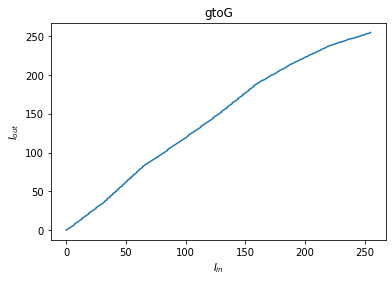

In [6]:
from scipy.optimize import minimize

y = np.array(cmaplookupDf['Iout'].values)
x = np.arange(0,256,1)
y = np.zeros(x.shape)

b = sp.interpolate.interp1d(cmaplookupDf['Iout'], cmaplookupDf['Iin'],bounds_error=False)

def diff(x,a):
    yt = b(x)
    return (yt - a)**2

for idx,x_value in enumerate(x):
    res = minimize(diff, 1.0, args=(x_value), method='Nelder-Mead', tol=1e-6)
    y[idx] = res.x[0]

plt.plot(np.round(y).astype('int'),x)
plt.title("gtoG")
plt.ylabel("$I_{out}$"); plt.xlabel("$I_{in}$");

cmaplookupDfInv = pd.DataFrame(np.array([np.round(y).astype('int'),x]).T, columns = ["Iin", "Iout"])

Gtog = gtoG$^{-1}$

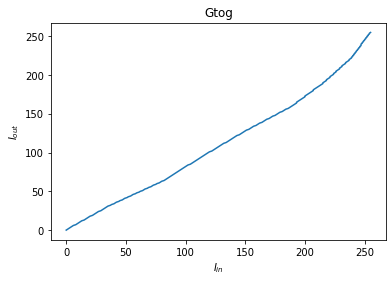

In [7]:
plt.plot(cmaplookupDf['Iin'], cmaplookupDf['Iout'])
plt.xlabel("$I_{in}$")
plt.ylabel("$I_{out}$")
plt.title("Gtog");

### Comparison of modulation of input images and images as shown on projector
(based on measured input->brightness curve and colour correction)

In [8]:
maxBit = 255 #assuming 8bit image depth
npts = 1000

def rescale(img):
    x = img.flatten()
    y = np.array(lookupDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

def simulateI(img):
    x = img.flatten()
    y = np.array(transformDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

def gtoG(img):
    x = (img).astype('int').flatten()
    y = np.array(cmaplookupDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

def Gtog(img):
    x = np.round(img).astype('int').flatten()
    y = np.array(cmaplookupDfInv.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

**Generate gradients**

In [9]:
panGrad = (np.sin(np.linspace(0,np.pi*2,npts)) + 1) *maxBit/2
panGradLow = (np.sin(np.linspace(0,np.pi*2,npts)) + 2)*maxBit/4
panGradVeryLow = (np.sin(np.linspace(0,np.pi*2,npts)) + 4)*maxBit/8

panGradLowBright = (np.sin(np.linspace(0,np.pi*2,npts)) + 2)*maxBit/4 + maxBit/4
panGradVeryLowBright = (np.sin(np.linspace(0,np.pi*2,npts)) + 4)*maxBit/8 + 3*maxBit/8

panWidth = np.linspace(0,1,npts)

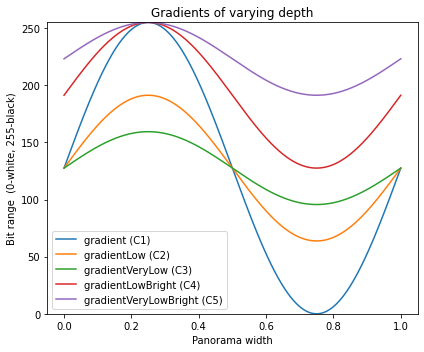

In [10]:
fig, axs = plt.subplots(1,1,figsize=(6,5))

axs.plot(panWidth,panGrad, label='gradient (C1)')
axs.plot(panWidth,panGradLow, label='gradientLow (C2)')
axs.plot(panWidth,panGradVeryLow, label='gradientVeryLow (C3)')
axs.plot(panWidth,panGradLowBright, label='gradientLowBright (C4)')
axs.plot(panWidth,panGradVeryLowBright, label='gradientVeryLowBright (C5)')
axs.set_title('Gradients of varying depth')
axs.set_ylim((0,maxBit))
axs.set_xlabel('Panorama width')
axs.set_ylabel('Bit range  (0-white, {}-black)'.format(maxBit));
axs.legend()
fig.tight_layout()

plt.savefig('plots/gradientModulationGenerated.pdf',dpi=400)

**Load screen brightess measurements and generate transforms of gradients**

In [11]:
Dir = 'screenMeasurements/' #"/Volumes/jayaramanlab/Shivam/" #connect to dm11
rig = "old_Hannah" #"Shivam"#

if rig == "Shivam":
    file2 = rig+"Rig_mean_brightness_level_6.csv"
else:
    file2 = rig+"Rig_mean_brightness.csv"
    
file = rig+"Rig_lookup_table_transformed_brightness.csv"

lookupDf = pd.read_csv(Dir+file,index_col=0)
mean_brightness = pd.read_csv(Dir+file2)

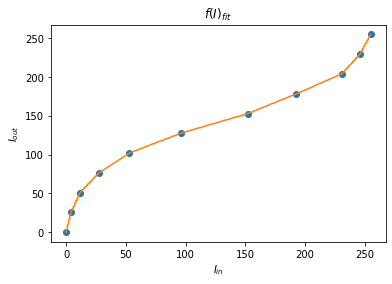

In [12]:
from scipy.optimize import minimize

y = np.array(mean_brightness['I'].values)
x = np.arange(0,256,1)
y = np.zeros(x.shape)

b = sp.interpolate.interp1d(mean_brightness['I'], mean_brightness['Stim'],bounds_error=False)

def diff(x,a):
    yt = b(x)
    return (yt - a)**2

for idx,x_value in enumerate(x):
    res = minimize(diff, 1.0, args=(x_value), method='Nelder-Mead', tol=1e-6)
    y[idx] = res.x[0]

plt.plot(mean_brightness['I'].values,mean_brightness['Stim'].values,'o');
plt.plot(np.round(y).astype('int'),x)
plt.title(r'$f(I)_{fit}$')
plt.ylabel("$I_{out}$"); plt.xlabel("$I_{in}$");

transformDf = pd.DataFrame(np.array([np.round(y).astype('int'),x]).T, columns = ["Iin", "Iout"])

In [73]:
def subplotter(x,y_vec,ax,f,l_vec):
    n = len(y_vec)
    for i,a in enumerate(ax.flatten()):
        if i<n:
            a.plot(x,f(y_vec[i]),label=l_vec[i])
        else:
            a.axis('off')
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


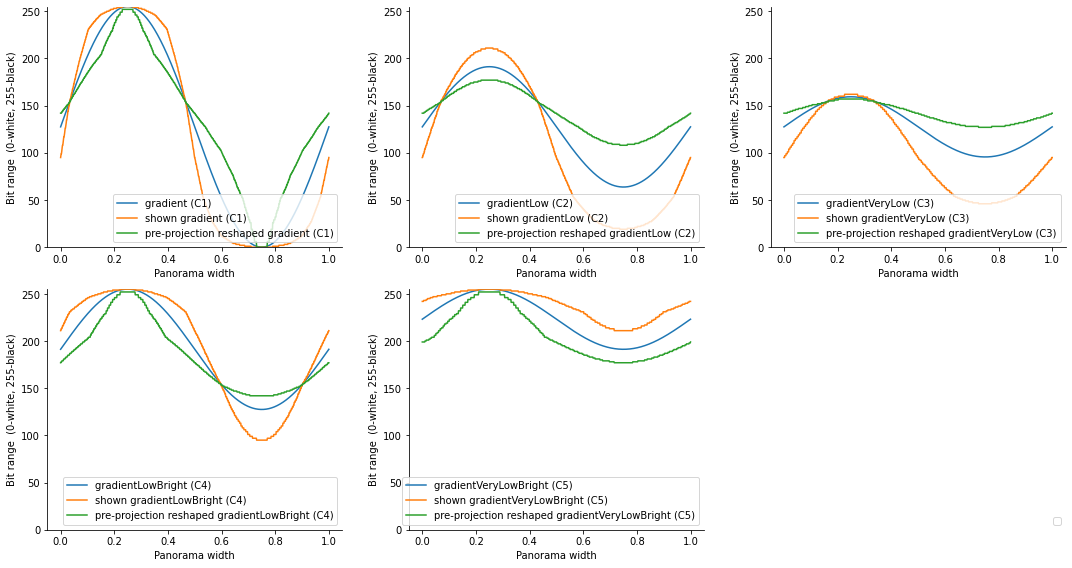

In [74]:
fig, axs = plt.subplots(2,3,figsize=(15,8),squeeze=False)

grads = np.array([panGrad, panGradLow, 
                     panGradVeryLow, panGradLowBright, panGradVeryLowBright])

labels = np.array(['gradient (C1)', 'gradientLow (C2)', 
          'gradientVeryLow (C3)', 'gradientLowBright (C4)', 
                   'gradientVeryLowBright (C5)'], dtype='object')

subplotter(panWidth, all_pans, axs, lambda x: x, labels)


if rig=="Shivam":
    
    subplotter(panWidth, all_pans, axs, lambda x: simulateI(Gtog(rescale(x))), "shown " +labels+ " v2")
    subplotter(panWidth, all_pans, axs, lambda x: simulateI(gtoG(x)),"shown "+labels)
    
else:
    
    subplotter(panWidth, all_pans, axs, lambda x: simulateI(x),"shown "+labels)

subplotter(panWidth, all_pans, axs, lambda x: rescale(x),"pre-projection reshaped "+labels)

for i in range(3):
    for ax in axs[:,i]:
        ax.set_ylim((0,maxBit))
        ax.set_xlabel('Panorama width')
        ax.set_ylabel('Bit range  (0-white, {}-black)'.format(maxBit));
        ax.legend(loc = "lower right")
fig.tight_layout()

plt.savefig('./plots/gradientModulationRescaled_{}Rig.pdf'.format(rig),dpi=400)

## Plot the gradients as they appear on the projector

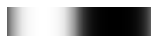

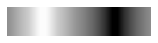

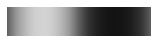

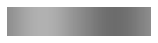

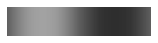

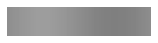

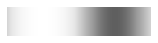

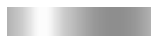

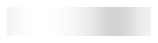

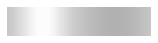

In [72]:
saveDir = "plots/shown"
Path(saveDir).mkdir(parents=True, exist_ok=True)

grads = ["gradient", "gradientLow", "gradientVeryLow", "gradientLowBright", "gradientVeryLowBright"]
for i, pan in enumerate(all_pans):
    
    if rig=="Shivam": 
        htfrac = 1280/720
        pan_shown = simulateI(gtoG(pan))
        pan_shown_v2 = simulateI(rescale(Gtog(pan)))
        pan_reshaped = rescale(pan)
        
    else: 
        htfrac = 72/360
        pan_shown = simulateI(pan)
        pan_reshaped = rescale(pan)
        
    ht = int(len(pan_shown)*htfrac)
    
    fig = plt.figure(frameon=False)
    fig.set_size_inches(2,2*htfrac)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(np.tile(pan_shown,ht).reshape(ht,len(pan_shown)), cmap='gray', 
               vmin=0, vmax=maxBit);
    plt.savefig(saveDir+"/{}_shown_{}Rig.png".format(grads[i],rig),dpi = 300);
    
    if rig=="Shivam":
        fig = plt.figure(frameon=False)
        fig.set_size_inches(2,2*htfrac)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        plt.imshow(np.tile(pan_shown_v2,ht).reshape(ht,len(pan_shown_v2)), cmap='gray', 
                   vmin=0, vmax=maxBit);
        plt.savefig(saveDir+"/{}_shown_v2_{}Rig.png".format(grads[i], rig),dpi = 300);
    
    fig = plt.figure(frameon=False)
    fig.set_size_inches(2,2*htfrac)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(np.tile(pan_reshaped,ht).reshape(ht,len(pan_reshaped)), cmap='gray', 
               vmin=0, vmax=maxBit);
    plt.savefig(saveDir+"/{}_reshaped_{}Rig.png".format(grads[i], rig),dpi = 300);

In [14]:
dotSizeAng = 12 #aim for x deg dot

if rig=="Shivam": htfrac = 1280/720
else: htfrac = 720/(480*4)
    
panHeight_px = int(np.shape(panGradLow)[0])
panWidth_px = int(panHeight_px*htfrac)

#convert angular dot size to pixel size and make dot
dotRad = panHeight_px * 0.5 * 0.5 * dotSizeAng/(180/np.pi)
mydot = disk(radius=dotRad)

dotpos_x = round(panWidth_px/2)
dotpos_y = round((panHeight_px + dotRad)/2)

pan = np.zeros((panWidth_px,panHeight_px),dtype=np.uint8)
pan[dotpos_x, dotpos_y] = maxBit
pan[:,:] = convolve2d(pan[:,:], mydot, boundary = 'wrap', mode='same')

pan = np.minimum(maxBit, pan)

In [15]:
darkSpot = pan[:,:]
brightSpot = abs(maxBit - darkSpot)

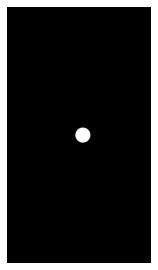

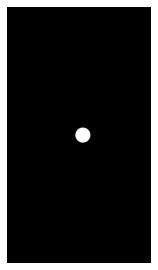

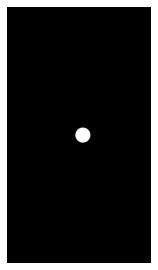

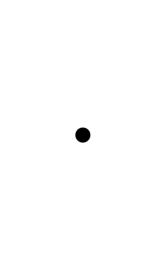

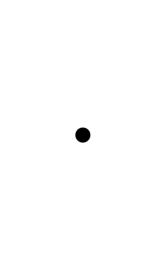

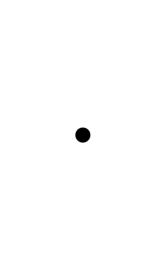

In [16]:
spots = ["brightSpot", "darkSpot"]

for i, pan in enumerate([darkSpot, brightSpot]):
    pan_shown = simulateI(gtoG(pan))
    pan_shown_v2 = simulateI(rescale(Gtog(pan)))
    pan_shown_reshaped = simulateI(rescale(pan))
    
    fig = plt.figure(frameon=False)
    fig.set_size_inches(2,2*htfrac)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(pan_shown, cmap='gray', 
               vmin=0, vmax=maxBit);
    plt.savefig(saveDir+"/{}_shown_{}Rig.png".format(spots[i],rig),dpi = 300);
    
    if rig=="Shivam":
        fig = plt.figure(frameon=False)
        fig.set_size_inches(2,2*htfrac)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        plt.imshow(pan_shown_v2, cmap='gray', 
                   vmin=0, vmax=maxBit);
        plt.savefig(saveDir+"/{}_shown_v2_{}Rig.png".format(spots[i], rig),dpi = 300);
        plt.savefig
    
    fig = plt.figure(frameon=False)
    fig.set_size_inches(2,2*htfrac)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(pan_shown_reshaped, cmap='gray', 
               vmin=0, vmax=maxBit);
    plt.savefig(saveDir+"/{}_shown_reshaped_{}Rig.png".format(spots[i], rig),dpi = 300);

In [17]:
panLeftShifted = np.roll(pan, -int(np.shape(pan)[1]/4), axis = 1)

In [18]:
spotGrads = np.array(["highSpot","midSpot","lowSpot"])

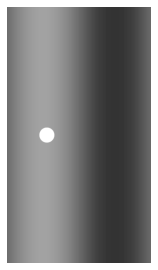

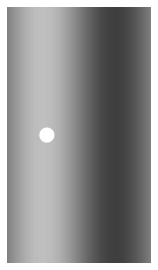

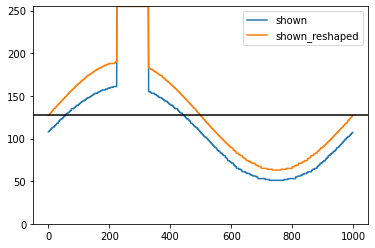

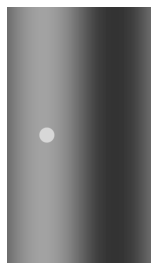

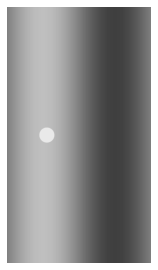

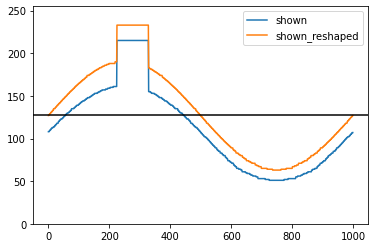

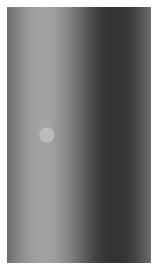

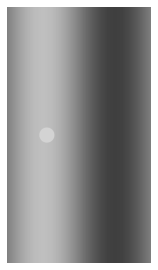

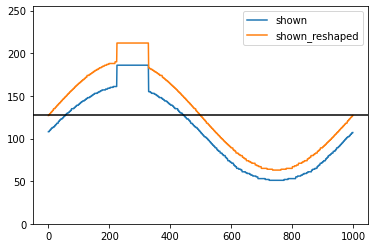

In [19]:
brightRange = np.linspace(255,np.max(panGradLow),len(spotGrads)+1)
for i,_ in enumerate(spotGrads):
    spotBrightness = brightRange[i]
    pan = np.where(panLeftShifted<255,spotBrightness,np.tile(panGradLow,ht).reshape(ht,len(panGradLow)))
    
    pan_shown = simulateI(rescale(Gtog(pan)))
    pan_shown_reshaped = simulateI(rescale(pan))
    
    if rig=="Shivam":
        fig = plt.figure(frameon=False)
        fig.set_size_inches(2,2*htfrac)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        plt.imshow(pan_shown, cmap='gray', 
                   vmin=0, vmax=maxBit);
        plt.savefig(saveDir+"/{}_shown_{}Rig.png".format(spotGrads[i], rig),dpi = 300);
    
    fig = plt.figure(frameon=False)
    fig.set_size_inches(2,2*htfrac)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(pan_shown_reshaped, cmap='gray', 
               vmin=0, vmax=maxBit);
    plt.savefig(saveDir+"/{}_shown_reshaped_{}Rig.png".format(spotGrads[i], rig),dpi = 300);
    
    plt.figure()
    plt.plot(pan_shown[int(np.shape(pan_shown)[0]/2),:])
    plt.plot(pan_shown_reshaped[int(np.shape(pan_shown_reshaped)[0]/2),:])
    plt.axhline(255/2,color='k')
    plt.legend(["shown", "shown_reshaped"])
    plt.ylim([0,255])

### Evaluation of gradients present in sky images

In [20]:
from PIL import Image
root = './skyGradients/originals/'
savename = '13h'
folder = savename+'/'# 'unity-skybox-16h-el48_52-az250_65/'#'unity-skybox-13h-el68_25-az169_56/'#

path = root + folder
maxBit = 255

In [21]:
grad_F = Image.open(path + 'SkyBox_Front.png')
grad_L = Image.open(path + 'SkyBox_Left.png')
grad_R = Image.open(path + 'SkyBox_Right.png')
grad_B = Image.open(path + 'SkyBox_Back.png')
grad_U = Image.open(path + 'SkyBox_Up.png')
grad_D = Image.open(path + 'SkyBox_Down.png')

arrB = np.zeros((grad_F.size[0],grad_F.size[1],6))
arrG = np.zeros((grad_F.size[0],grad_F.size[1],6))
arrR = np.zeros((grad_F.size[0],grad_F.size[1],6))

arrAll = np.zeros((grad_F.size[0],grad_F.size[1],4,6))

arrAll[:,:,:,2] = np.array(grad_F)
arrAll[:,:,:,3] = np.array(grad_L)
arrAll[:,:,:,0] = np.array(grad_B)
arrAll[:,:,:,1] = np.array(grad_R)
arrAll[:,:,:,4] = np.array(grad_U)
arrAll[:,:,:,5] = np.array(grad_D)

horizon = int(grad_F.size[1]/2)

In [22]:
# make long array by concatenating side faces, clip out bottom part (below horizon)

arrSides = np.zeros((horizon,grad_F.size[1]*4,4))
for i in range(4):
    arrSides[:,grad_F.size[1]*i:grad_F.size[1]*(i+1),:] = arrAll[:horizon,:,:,i]
    
cmaps = ['Reds','Greens','Blues']
lab = ['red','green','blue']

elevation = np.linspace(0,horizon-1,7).astype('int')

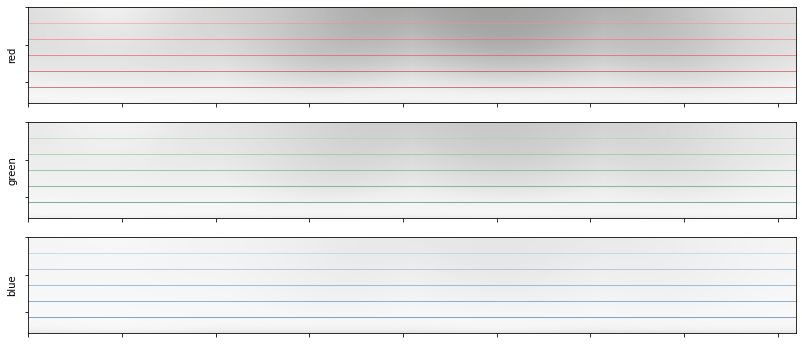

In [23]:
fig, axs = plt.subplots(3,1,figsize=(15,6))

for c in range(3):
    axs[c].imshow(arrSides[:,:,c], cmap='Greys_r', vmin=150, vmax=255)
    cNorm  = colors.Normalize(vmin=-1, vmax=len(elevation)) 
    myCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=cmaps[c])
    for i, e in enumerate(elevation):
        axs[c].axhline(e,color=myCMap.to_rgba(i+1), linewidth=0.5)
    axs[c].axes.xaxis.set_ticklabels([])
    axs[c].axes.yaxis.set_ticklabels([])
    axs[c].set_ylabel(lab[c])
plt.savefig('./plots/skygradients_RGB_original_{}.pdf'.format(savename))

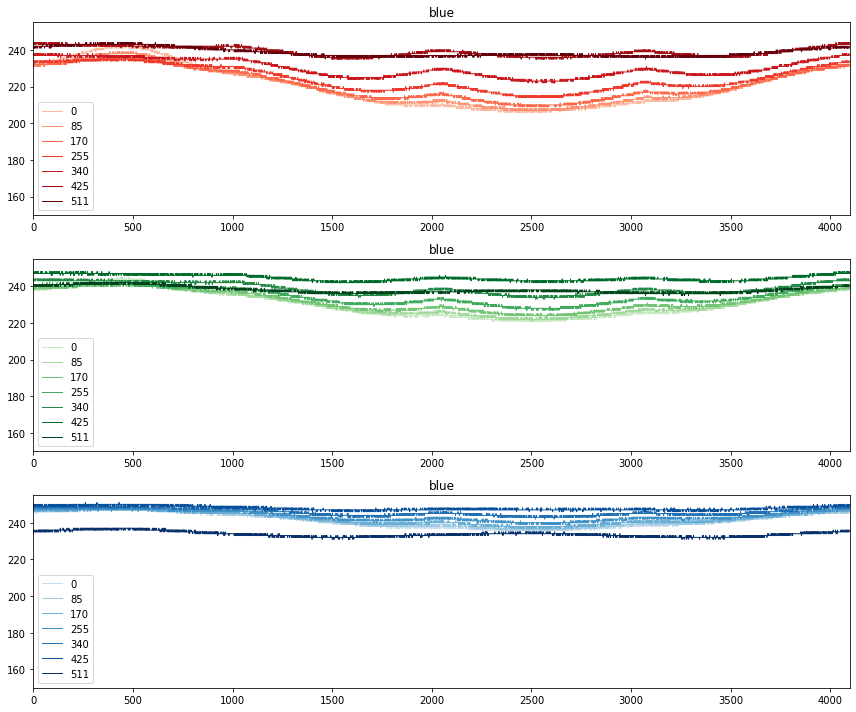

In [24]:
fig, axs = plt.subplots(3,1,figsize=(12,10))
for c in range(3):
    cNorm  = colors.Normalize(vmin=-1, vmax=len(elevation)) 
    myCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=cmaps[c])
    for i, e in enumerate(elevation):
        axs[c].plot(arrSides[e,:,c],'-',color=myCMap.to_rgba(i+1), label=e, linewidth=1)

for i, ax in enumerate(axs):
    ax.set_ylim(150,255)
    ax.set_xlim(0,grad_F.size[1]*4)
    ax.legend()
    ax.set_title(lab[c])
fig.tight_layout()
plt.savefig('./plots/skygradients_RGB_elevationProfile_{}.pdf'.format(savename))

### Rescale naturalistic gradients to make them span a range from 150 - 255

In [25]:
increase = 200

In [26]:
arrSidesScaled = (arrSides[:,:,:] - increase)
arrSidesScaled = (arrSidesScaled/np.max(arrSidesScaled[:,:,:]))
arrSidesScaled = maxBit *(arrSidesScaled)

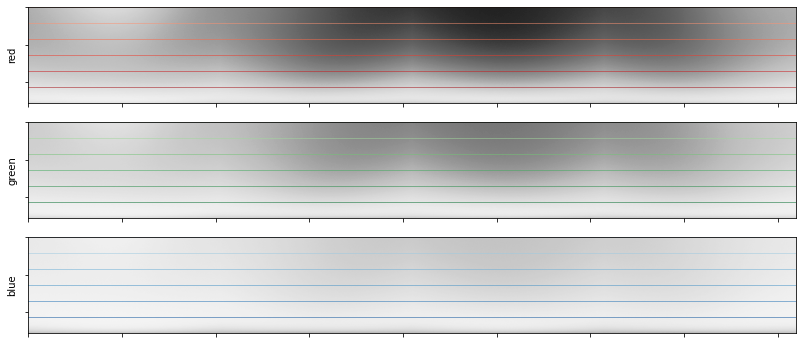

In [27]:
fig, axs = plt.subplots(3,1,figsize=(15,6))

for c in range(3):
    axs[c].imshow(arrSidesScaled[:,:,c], cmap='Greys_r', vmin=0, vmax=255)
    cNorm  = colors.Normalize(vmin=-1, vmax=len(elevation)) 
    myCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=cmaps[c])
    for i, e in enumerate(elevation):
        axs[c].axhline(e,color=myCMap.to_rgba(i+1), linewidth=0.5)
    axs[c].axes.xaxis.set_ticklabels([])
    axs[c].axes.yaxis.set_ticklabels([])
    axs[c].set_ylabel(lab[c])
plt.savefig('./plots/skygradients_RGB_rescaled_{}.pdf'.format(savename))

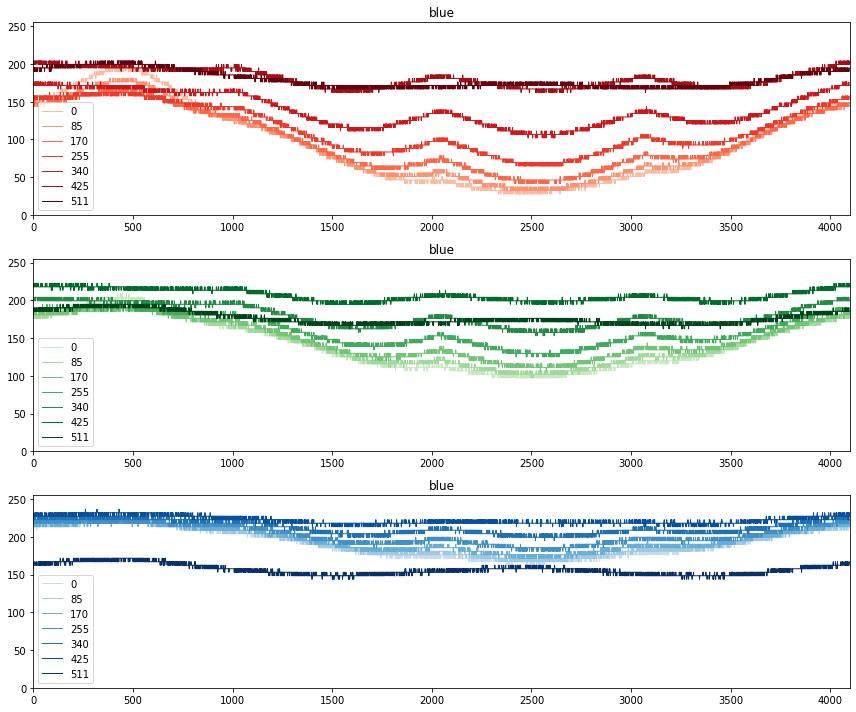

In [28]:
fig, axs = plt.subplots(3,1,figsize=(12,10))
for c in range(3):
    cNorm  = colors.Normalize(vmin=-1, vmax=len(elevation)) 
    myCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=cmaps[c])
    for i, e in enumerate(elevation):
        axs[c].plot(arrSidesScaled[e,:,c],'-',color=myCMap.to_rgba(i+1), label=e, linewidth=1)

for i, ax in enumerate(axs):
    ax.set_ylim(0,255)
    ax.set_xlim(0,grad_F.size[1]*4)
    ax.legend()
    ax.set_title(lab[c])
fig.tight_layout()
plt.savefig('./plots/skygradients_RGB_elevationProfileRescaled_{}.pdf'.format(savename))

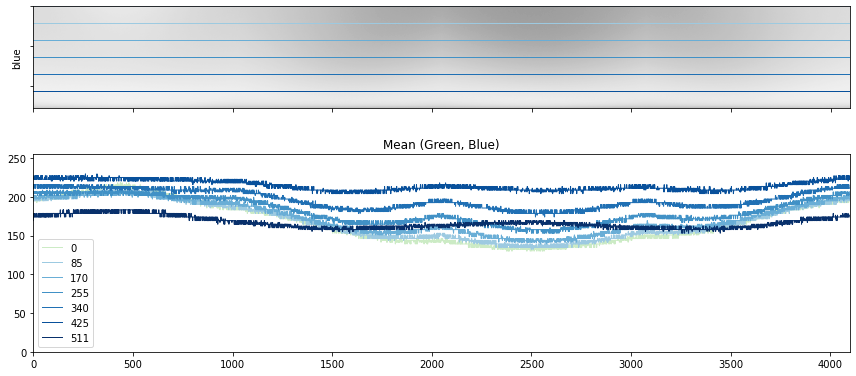

In [29]:
arrSidesScaledBG = (arrSidesScaled[:,:,1]  + arrSidesScaled[:,:,2])/2

fig, axs = plt.subplots(2,1,figsize=(12,6))

cNorm  = colors.Normalize(vmin=-1, vmax=len(elevation)) 
myCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='GnBu')
for i, e in enumerate(elevation):
    axs[1].plot(arrSidesScaledBG[e,:],'-',color=myCMap.to_rgba(i+1), label=e, linewidth=1)
    axs[0].imshow(arrSidesScaledBG, cmap='Greys_r', vmin=0, vmax=255)
    cNorm  = colors.Normalize(vmin=-1, vmax=len(elevation)) 
    myCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=cmaps[c])
    for i, e in enumerate(elevation):
        axs[0].axhline(e,color=myCMap.to_rgba(i+1), linewidth=0.5)
axs[0].axes.xaxis.set_ticklabels([])
axs[0].axes.yaxis.set_ticklabels([])
axs[0].set_ylabel(lab[c])

axs[1].set_ylim(0,255)
axs[1].set_xlim(0,grad_F.size[1]*4)
axs[1].legend()
axs[1].set_title('Mean (Green, Blue)')
fig.tight_layout()
plt.savefig('./plots/skygradients_GBmeanRescaled_imageAndElevationProfile_{}.pdf'.format(savename))